In [12]:
import pandas as pd
import featuretools as ft
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Define the data as provided in the scenario for each entity
customers_data = {
    'CustomerID': [101, 102, 103],
    'Name': ['John Doe', 'Jane Smith', 'Mike Jordan'],
    'Email': ['john.doe@example.com', 'jane.smith@example.com', 'mike.jordan@example.com'],
    'SignupDate': ['2023-01-10', '2023-01-15', '2023-01-20'],
    'Address':  ['1, Jalan Megah, 41050, Klang, Selangor', 
                 '2, Jalan Bahagia, 40170, Shah Alam, Selangor', 
                 '3, Jalan Ceria, 83000, Batu Pahat, Johor'],
    'Postcode': ['41050', '40170', '83000'],
    'City': ['Klang', 'Shah Alam', 'Batu Pahat'],
    'State': ['Selangor', 'Selangor', 'Johor'],
}

products_data = {
    'ProductID': [201, 202, 203],
    'Name': ['Laptop', 'Tablet', 'Smartphone'],
    'Category': ['Electronics', 'Electronics', 'Electronics'],
    'Price': [1000, 500, 800]
}

orders_data = {
    'OrderID': [301, 302, 303, 304, 305, 306],
    'CustomerID': [101, 102, 102, 103, 103, 103],
    'OrderDate': ['2021-02-01', '2021-02-05', '2022-09-20','2021-07-15', '2022-08-20', '2023-02-10'],
    'ShipDate': ['2021-02-03', '2021-02-07', '2022-09-30', '2021-07-17', '2022-08-22',  '2023-02-12']
}

order_details_data = {
    'OrderID': [301, 302, 303, 304, 305, 306],
    'ProductID': [201, 202, 203, 202, 201, 203],
    'Quantity': [1, 2, 1, 3, 1, 1],
    'Discount': [0, 0.9, 0, 0.05, 0, 0.9]
}

# Convert the data into pandas DataFrames
customers_df = pd.DataFrame(customers_data)
products_df = pd.DataFrame(products_data)
orders_df = pd.DataFrame(orders_data)
order_details_df = pd.DataFrame(order_details_data)

# Convert the SignupDate, OrderDate, and ShipDate to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
orders_df['OrderDate'] = pd.to_datetime(orders_df['OrderDate'])
orders_df['ShipDate'] = pd.to_datetime(orders_df['ShipDate'])


In [15]:
# Create an EntitySet
es = ft.EntitySet(id='ecommerce_data')

# Add dataframes
es = es.add_dataframe(dataframe_name='customers',dataframe=customers_df,index='CustomerID',time_index='SignupDate')
es = es.add_dataframe(dataframe_name='products',dataframe=products_df,index='ProductID')
es = es.add_dataframe(dataframe_name='orders',dataframe=orders_df,index='OrderID',time_index='OrderDate')
es = es.add_dataframe(dataframe_name='order_details',dataframe=order_details_df,make_index=True,index='OrderDetailsID')

# Add relationships
es = es.add_relationship('customers', 'CustomerID', 'orders', 'CustomerID')
es = es.add_relationship('orders', 'OrderID', 'order_details', 'OrderID')
es = es.add_relationship('products', 'ProductID', 'order_details', 'ProductID')

es


Entityset: ecommerce_data
  DataFrames:
    customers [Rows: 3, Columns: 8]
    products [Rows: 3, Columns: 4]
    orders [Rows: 6, Columns: 4]
    order_details [Rows: 6, Columns: 5]
  Relationships:
    orders.CustomerID -> customers.CustomerID
    order_details.OrderID -> orders.OrderID
    order_details.ProductID -> products.ProductID

In [17]:
# Assuming 'es' is your EntitySet and is correctly set up
feature_matrix, feature_defs = ft.dfs(entityset=es, 
                                      target_dataframe_name='orders')


file_path = '/Users/wanying/Desktop/feature_matrix.xlsx'
feature_matrix.to_excel(file_path, index=False)


feature_defs


[<Feature: CustomerID>,
 <Feature: COUNT(order_details)>,
 <Feature: MAX(order_details.Discount)>,
 <Feature: MAX(order_details.Quantity)>,
 <Feature: MEAN(order_details.Discount)>,
 <Feature: MEAN(order_details.Quantity)>,
 <Feature: MIN(order_details.Discount)>,
 <Feature: MIN(order_details.Quantity)>,
 <Feature: SKEW(order_details.Discount)>,
 <Feature: SKEW(order_details.Quantity)>,
 <Feature: STD(order_details.Discount)>,
 <Feature: STD(order_details.Quantity)>,
 <Feature: SUM(order_details.Discount)>,
 <Feature: SUM(order_details.Quantity)>,
 <Feature: DAY(OrderDate)>,
 <Feature: DAY(ShipDate)>,
 <Feature: MONTH(OrderDate)>,
 <Feature: MONTH(ShipDate)>,
 <Feature: WEEKDAY(OrderDate)>,
 <Feature: WEEKDAY(ShipDate)>,
 <Feature: YEAR(OrderDate)>,
 <Feature: YEAR(ShipDate)>,
 <Feature: customers.Postcode>,
 <Feature: MAX(order_details.products.Price)>,
 <Feature: MEAN(order_details.products.Price)>,
 <Feature: MIN(order_details.products.Price)>,
 <Feature: SKEW(order_details.products

Insight 1: Customer Experience and Retention

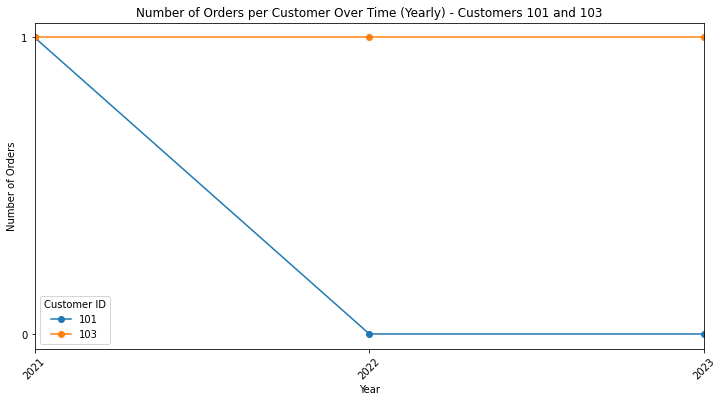

In [30]:
# Convert the OrderDate to datetime
orders_df['OrderDate'] = pd.to_datetime(orders_df['OrderDate'])

# Aggregate orders by CustomerID and year of OrderDate
orders_df['Year'] = orders_df['OrderDate'].dt.to_period('Y')  # Yearly aggregation
orders_time_series = orders_df.groupby(['CustomerID', 'Year']).size().reset_index(name='OrderCount')

# Pivot the data for easier plotting
pivot_table = orders_time_series.pivot(index='Year', columns='CustomerID', values='OrderCount').fillna(0)

# Filter to only include data for CustomerID 101
filtered_pivot_table = pivot_table[[101, 103]]

# Plotting
filtered_pivot_table.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Number of Orders per Customer Over Time (Yearly) - Customers 101 and 103')
plt.xlabel('Year')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.legend(title='Customer ID')

# Adjust y-axis to fit the range of orders
max_count = filtered_pivot_table.max().max()  # Get the maximum count from the filtered table
plt.yticks(np.arange(0, max_count + 1, 1))

plt.show()



Insight 2: Emerging Market and Consumer Trends

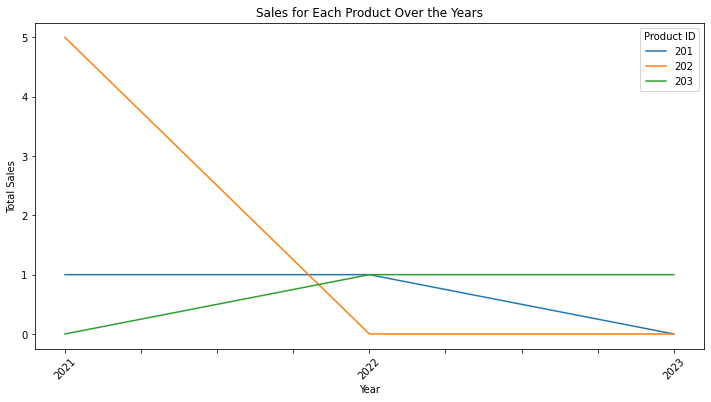

In [72]:
# Group sales data by product and year
product_yearly_sales = order_details_df.merge(orders_df[['OrderID', 'OrderDate']], left_on='OrderID', right_index=True)

# Extract the year from the 'OrderDate' column
product_yearly_sales['OrderYear'] = product_yearly_sales['OrderDate'].dt.year

# Convert 'ProductID' to string
product_yearly_sales['ProductID'] = product_yearly_sales['ProductID'].astype(str)

# Now, you can group by 'ProductID' and 'OrderYear' and calculate the sum of 'Quantity'
product_yearly_sales = product_yearly_sales.groupby(['ProductID', 'OrderYear'])['Quantity'].sum().unstack().fillna(0)

# Reset the index
product_yearly_sales.reset_index(inplace=True)

# Set 'ProductID' as the index
product_yearly_sales.set_index('ProductID', inplace=True)

# Transpose the DataFrame
product_yearly_sales = product_yearly_sales.T

# Plotting
product_yearly_sales.plot(kind='line', figsize=(12, 6))
plt.title('Sales for Each Product Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Product ID')
plt.show()


Insight 3: Impact of Pricing Strategies and Discount Campaigns on Market Performance

/var/folders/l3/pvwrg9552b3crp5qxqmdj16m0000gn/T/ipykernel_8541/1496869692.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_sales_volume = feature_matrix.groupby('Discount Category').size()


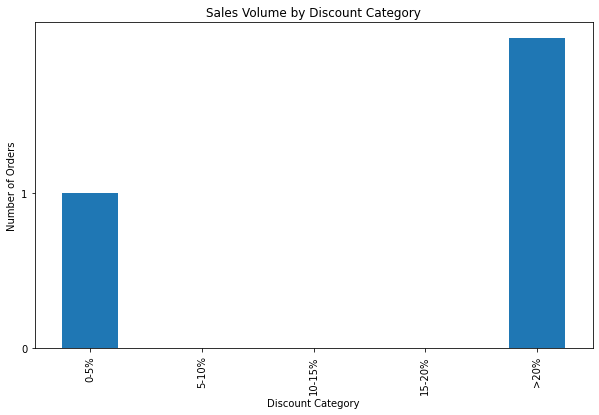

In [96]:
# Categorizing discounts into bins
feature_matrix['Discount Category'] = pd.cut(feature_matrix['MEAN(order_details.Discount)'], bins=[0, 0.05, 0.1, 0.15, 0.2, 1], labels=['0-5%', '5-10%', '10-15%', '15-20%', '>20%'])

discount_sales_volume = feature_matrix.groupby('Discount Category').size()

discount_sales_volume.plot(kind='bar', figsize=(10, 6))
plt.title('Sales Volume by Discount Category')
plt.xlabel('Discount Category')
plt.ylabel('Number of Orders')
max_count = filtered_pivot_table.max().max()  # Get the maximum count from the filtered table
plt.yticks(np.arange(0, max_count + 1, 1))
plt.show()
